In [32]:
import pandas as pd
import numpy as np
import joblib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
filepath='diabetes_dataset.csv'
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

if __name__ == "__main__":
    df = load_data(filepath)
df.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


In [34]:
df.shape

(9538, 17)

In [35]:
# Calculate mean and std of Glucose
glucose_mean = df['Glucose'].mean()
glucose_std = df['Glucose'].std()

# Save to a file
#np.savez('glucose_stats.npz', mean=glucose_mean, std=glucose_std)

In [36]:
# Create BMI categories
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Create Age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['18-30', '31-50', '51+'])

# Create Glucose categories
df['Glucose_Category'] = pd.cut(df['Glucose'], bins=[0, 99, 125, 300], labels=['Normal', 'Prediabetes', 'Diabetes'])

In [37]:
# One-hot encoding for categorical variables
df = pd.get_dummies(df, columns=['BMI_Category', 'Age_Group', 'Glucose_Category'], drop_first=True)

In [38]:
from sklearn.preprocessing import StandardScaler
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['Age', 'BMI', 'Glucose', 'BloodPressure', 'HbA1c', 'LDL', 'HDL', 'Triglycerides', 'WaistCircumference', 'HipCircumference', 'WHR']
df[numerical_features] = scaler.fit_transform(df[numerical_features])
# if needed get model of scaler
#joblib.dump(scaler,'scaler.pkl')

In [39]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
# Predict on the test set
y_pred = model.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1274    1]
 [  19  614]]


In [43]:
from sklearn.metrics import classification_report

# Classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1275
           1       1.00      0.97      0.98       633

    accuracy                           0.99      1908
   macro avg       0.99      0.98      0.99      1908
weighted avg       0.99      0.99      0.99      1908



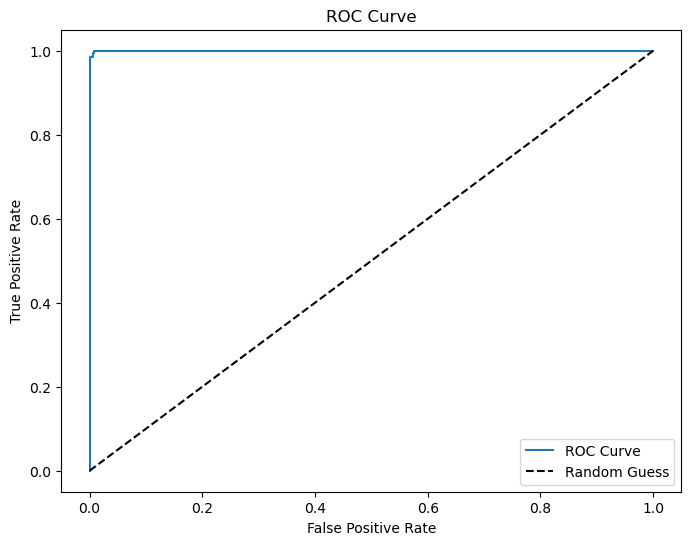

AUC Score: 0.9998822909890654


In [44]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC curve
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
#plt.savefig('ROC Curve')
plt.show()

# AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

In [45]:
# Feature importance from logistic regression
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print("Feature Importance:")
print(feature_importance)

Feature Importance:
                         Feature  Coefficient
12                 FamilyHistory    14.352078
3                        Glucose     3.951976
5                          HbA1c     0.442587
2                            BMI     0.249800
9             WaistCircumference     0.217016
0                            Age     0.138233
13                      DietType     0.070522
8                  Triglycerides     0.047971
14                  Hypertension     0.034044
6                            LDL     0.018380
7                            HDL     0.017370
15                 MedicationUse     0.013266
4                  BloodPressure     0.002413
1                    Pregnancies    -0.014890
11                           WHR    -0.256859
10              HipCircumference    -0.273244
19               Age_Group_31-50    -0.426687
20                 Age_Group_51+    -0.600558
16           BMI_Category_Normal    -0.672870
18            BMI_Category_Obese    -0.831365
17       BMI_C

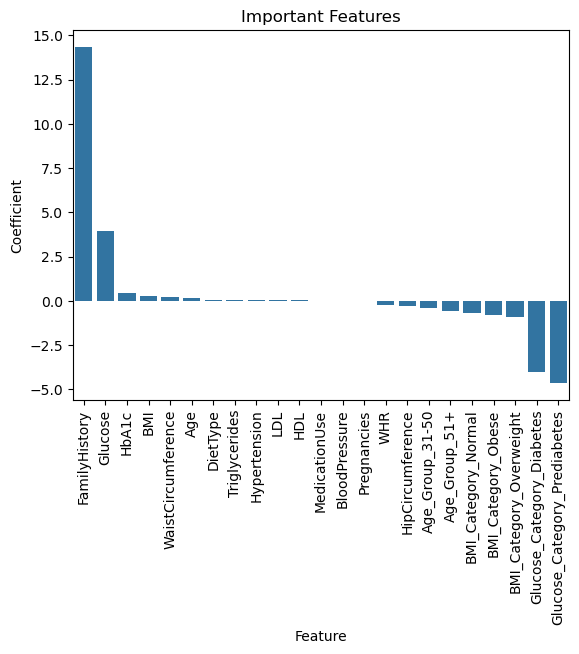

In [46]:
sns.barplot(x='Feature',y='Coefficient',data=feature_importance)
plt.title('Important Features')
plt.xticks(rotation=90)
#plt.savefig('Important Features',bbox_inches='tight')
plt.show()

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Feature importance
rf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importance:")
print(rf_feature_importance)

Random Forest Feature Importance:
                         Feature  Importance
12                 FamilyHistory    0.782600
3                        Glucose    0.096159
5                          HbA1c    0.022895
2                            BMI    0.011537
22     Glucose_Category_Diabetes    0.010743
10              HipCircumference    0.008602
9             WaistCircumference    0.008542
7                            HDL    0.007995
0                            Age    0.007932
4                  BloodPressure    0.007910
6                            LDL    0.007797
8                  Triglycerides    0.007595
11                           WHR    0.006078
1                    Pregnancies    0.004896
21  Glucose_Category_Prediabetes    0.001906
13                      DietType    0.001646
15                 MedicationUse    0.001363
18            BMI_Category_Obese    0.001088
16           BMI_Category_Normal    0.000722
19               Age_Group_31-50    0.000706
20                 Ag

In [48]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Best Parameters: {'C': 10, 'penalty': 'l2'}


C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\desktop\data_science_project

In [49]:
# Train on the full dataset
final_model = LogisticRegression(C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'])
final_model.fit(X, y)

C:\Users\User\desktop\data_science_project\Venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

import joblib

# Save the model
joblib.dump(final_model, 'diabetes_prediction_model.pkl')